## <p style="text-align: center;">An Introduction to Astrophysics Data Analysis in Python/Jupyter Notebook</p>

<p style="text-align: center;"> Samuel Whitebook </p>

This Notebook will cover the basics of using Python to analyze astrophysics data, particularly images.

In [1]:
#Our bookkeeping cell
import os #This package allows you to interact with your operating system
import numpy as np #standard math library: https://numpy.org/doc/stable/
import matplotlib.pyplot as plt #standard plotting library: https://matplotlib.org/stable/index.html
from astropy.io import fits #Astropy is a multi-purpose python package made by astronomers: https://docs.astropy.org/en/stable/index.html
from astropy.stats import * #Astropy is massive and we only want specific tools from it for now, so it's best to import only what we need.
from photutils.background import Background2D, MedianBackground #Photutils is another package used to manipulate images and find sources in our images.
from photutils.detection import DAOStarFinder #Photutils documentation: https://photutils.readthedocs.io/en/stable/
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

import warnings
warnings.filterwarnings('ignore') #I turn off warnings because python complains about log values, but doesn't actually break. You may want to leave these on when experimenting.

Astrophysics coding follows the same general steps most of the time <br>
1) Import your data and extract relevant information <br>
2) Clean your data <br>
3) Analyze your data <br>

Lets make some code to handle a basic example, starting by importing and opening our data <br>
<br>
Astrophysics data almost always comes in the form of fits files. Fits (flexible image transport system) files come with a data extension and a header extension. The data of a fits file is the image itself, sometimes along with other things like bad pixel masks. The header is a table of information about the image that is relevant to using data from it.

Included with this tutorial was an LCO image. We're going to open it.

In [2]:
#First define the image in python as a string.
imagefile = "Test_Image.fits" #Here I am assuming the image is in the same location on my computer as my python notebook. Use the below code for more flexibility:
# imagefile = r"C:\Users\Sam Whitebook\Test_Image.fits" #Replacing the path with wherever your image actually is. The r is necessary to define a "string literal" so python knows the \'s are for a path.

#Now we will use astropy to open the file. Note that sometimes LCO files come with multiple extensions for data and headers. You may need to index through your data to find your image.
image = fits.open(imagefile)[0].data
header = fits.open(imagefile)[0].header

The data of our image is a matrix of pixel values representing a brightness (photon count incident on the detector) at a pixel. We can show it in python with matplotlib imshow.

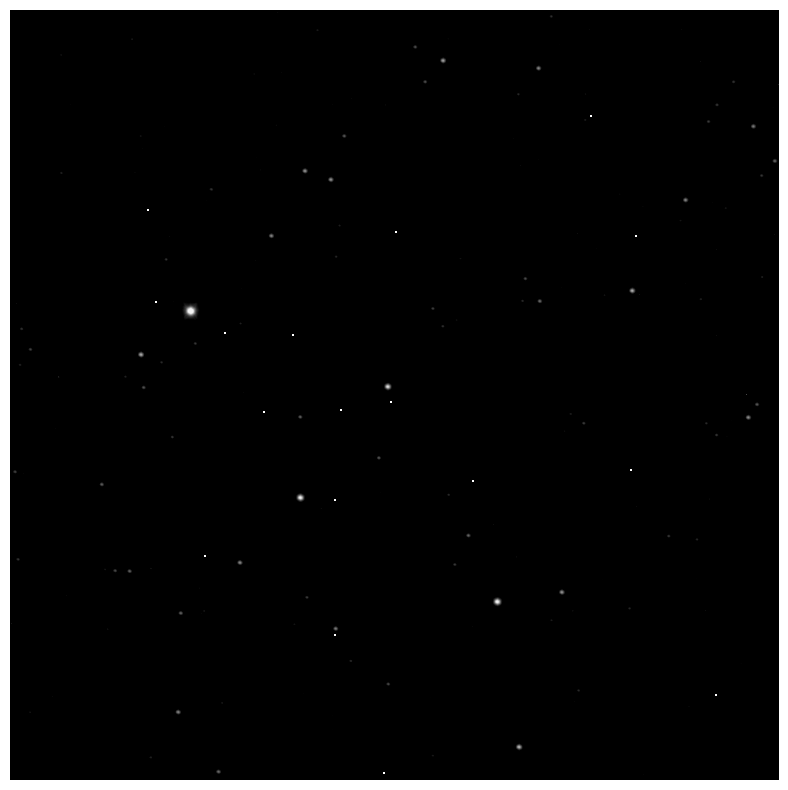

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), #We usually take the log of an image to see the variance of the pixels better.
            origin='lower', #This tells matplotlib where the [0,0] index is. For our images it is in the bottom.
            cmap = "gray", #Use whatever colormap you like, but I find gray the easiest to visualize.
            vmin = 6, vmax = 11) #This defines the data range we want to see. There are ways to automate this but I always do it manually.
plt.axis('off') #This removes the axes, which aren't really relevant for just viewing an image.
plt.show()

Our header is imported as an "astropy header" object, which is really just a fancy dictionary.

In [4]:
#The header has a bunch of 'cards' which are like dictionary keys. Calling header.cards lists all the possible cards. You may uncomment and call the function below, but it is a large output.

# print(header.cards)

#Lets call the Modified Julian Date for when this image was taken.
mjd = header['MJD-OBS']
print("The Modified Julian Date is", mjd)

The Modified Julian Date is 56370.08241256944


Ok, so now we know how to import our data, but as of now that's just a pretty picture. It still has background noise, and we don't know how many stars are in it, or how bright they are. <br>
Next we will do some basic photometry using the rest of the tools we have imported. Unfortunately many of these tools are what we call "black boxes" in that they take an input and give you an output, but attempting to understand how they do so is a difficult exercise that we often do not concern ourselves with.

In [5]:
#In order to run photometry we need to first process our images.

#First we ned to do some statistics
sigma_clip = SigmaClip(sigma=3.0) #A sigma clip excludes values that are a certain number of standatd deviations, sigma, above the mean. We don't include these in our background because they're stars.
mean, median, std = sigma_clipped_stats(image, sigma=3.0) #Here astropy just does some statistics for us. Use the same sigma as you choose for the clip. 3 is usually good.

bkg_estimator = MedianBackground() #This specifies which method of estimating the background photutils uses. We almost always want to stick with median.
bkg = Background2D(image, #Which image to make a background for
                    box_size=(50, 50), #Box size tells the function how much of the image to parse at once. Leave it at 50x50 usually.
                    filter_size=(3, 3), #3x3 is default for the filter size. I honestly don't know what a 'median filter' is, but this has always worked.
                    sigma_clip=sigma_clip, #Just use the sigma clip we defined earlier.
                    bkg_estimator=bkg_estimator) #Same thing for the background estimator method.
bkg_median = bkg.background_median #This pulls the median of the background values.

In [6]:
#Now let's find some sources using DAO Star Finder.

daofind = DAOStarFinder(fwhm=5, #This is the full width half maximum of the 'gaussian kernel' of the starfinder in units of pixels. Smaller values will find more sources, large values will find less.
                        threshold=5*std) #The threshold determines at what pixel value the starfinder will call something a source. We usually use a multiple of the standard deviation we found earlier. Again smaller for more.
sources = daofind(image - bkg_median) #We subtract the median we found earlier from the whole image.
print(sources)

 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 1749.6722964502692 ... 1.6032484743911712  -0.5125020883158379
  2 1684.6856903468224 ...   2.49185198931636  -0.9913056064724611
  3  554.4240082935423 ...  31.68530095186122   -3.752144591191566
  4   931.215280266293 ...  2.169095330117642  -0.8406965983783355
  5   329.221850017824 ...  1.608564323555064  -0.5160960805747214
  6  374.2312436964301 ...  5.457168885157336  -1.8424184856842543
  7 1124.2510269535228 ...  5.051525134945578  -1.7585562956396497
  8 1249.5597843565047 ... 1.4210136074125217 -0.38149559171500835
  9  1353.427292828872 ... 170.94540995386117   -5.582143610177654
 10  1462.009582439259 ...  1.822576470846931  -0.6517143982639407
...                ... ...                ...                  ...
189  557.8488756115373 ... 1.1815385082980552  -0.1811197014398426
190 1077.3263765735342 ... 18.307197108986752   -3.15655464375

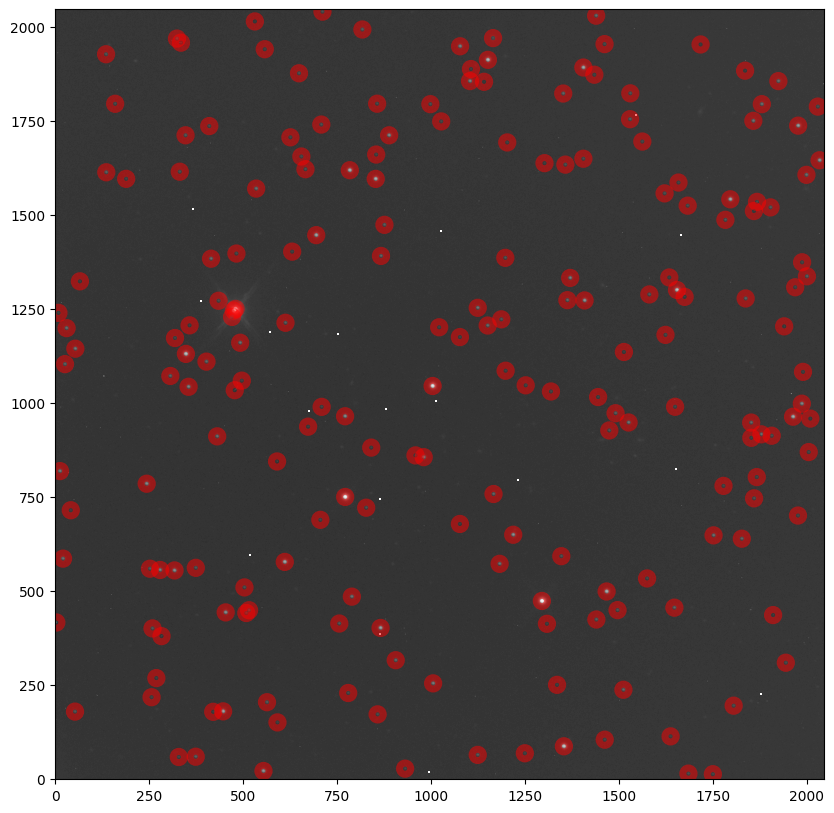

In [7]:
#Now we know where our sources are, we can do some aperture photometry to get values of their brightness.

positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=15) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)
v = apertures.plot(color='red', lw=5, alpha=0.5) #I define it as a variable to avoid unnecessary readout.
plt.show()

We can see that what our apertures find is very reliant on what we choose for our FWHM and threshold.

In [8]:
#We can make a photometry table using the aperture photometry function.
phot_table = aperture_photometry(image - bkg_median, apertures) #We use the aperture photometry function to list the photon sums and positions of the sources we found.
print(phot_table)

 id      xcenter            ycenter          aperture_sum   
           pix                pix                           
--- ------------------ ------------------ ------------------
  1 1749.6722964502692  13.03272855286243  18033.25060972392
  2 1684.6856903468224 14.514489075158062 19356.519193499746
  3  554.4240082935423  21.50844832373623 154547.95010315973
  4   931.215280266293 27.752529467139315  6176.403817021994
  5   329.221850017824  58.76796996144639  5475.239063275563
  6  374.2312436964301   59.5087644573645 25423.189289458278
  7 1124.2510269535228  64.35538952167057  22305.69834355636
  8 1249.5597843565047  68.67330808851015  6438.950102936609
  9  1353.427292828872  87.22628167676544  752536.3039244664
 10  1462.009582439259 104.79131560558432 13593.386405738947
...                ...                ...                ...
190 1077.3263765735342 1949.1045929947134  88467.38269143301
191 1461.5857279360655 1954.8395587210791  18550.84763928053
192  1716.972906628664  

In [9]:
#I will define a function to do all our photometry for us. It appears long, but much of this code can be copy pasted for your own work.

#Most of these black box functions come from astropy stats and photutils. I will briefly explain what they do and what their inputs are, but not how they work.
def photometry(data, header):
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    time = header["MJD-OBS"] #I am simply returning the modified julian date off the header for convenience.
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    bkg = Background2D(data, box_size=(50, 50), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    bkg_median = bkg.background_median
    daofind = DAOStarFinder(fwhm=10, threshold=5*std)
    sources = daofind(data - bkg_median)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=15)
    phot_table = aperture_photometry(data - bkg_median, apertures)
    aperture_sums = phot_table['aperture_sum']
    return time, positions, aperture_sums

That was a lot. Lets call our photometry function on our image and see what it finds.

In [10]:
time, positions, sums = photometry(image, header)
print("We found", len(sums), "stars")

#Lets call a random star and see what information we found on it.
star_index = np.random.randint(0,283)
star_position = positions[star_index]
star_photons = sums[star_index]
print("The star's pixel position is", star_position)
print("The star's photon count is", star_photons)

We found 283 stars
The star's pixel position is [218.75752288 130.77654652]
The star's photon count is -5093.428581491473


What you would do with this information is dependent on your project, but for an example of a time series for exoplanet transits, you may wish to refer to a piece of code I have on my github for treating a transiting exoplanet (Actually the source of this image if you were curious.)

Link:https://github.com/Sewhitebook/Sewhitebook/blob/main/Transiting_Exoplanets.ipynb

As a follow up I will quickly go over converting your aperture sums to magnitudes and calibrating your measurements to accepted values.

We can use our aperture sums as measures of flux, which we can convert to magnitudes. Using a few known objects in our images as calibration stars, we can match our measurements to accepted values using a "Zero Point Correction"

The model for our own magnitudes is $$m = -2.5log_{10}(N_\textrm{aperture sum})$$

Assuming our on-sky magnitude, $M_\textrm{sky}$ is given by

$$ M_\textrm{sky} - m = \textrm{ZP} $$

Where $\textrm{ZP}$ is the zero point magnitude of our images, we can find $\textrm{ZP}$ by taking the average of the zero point we find for our calibration stars.

I'm going to find four stars for examples.

The general method I use is to search the object in our image on sky-map.org, a visualization website of the sky. Then, finding several objects in my image (crucially, not the one I am doing science on to avoid zero point bias), I find differences between the accepted on sky magnitude and the magnitudes I measure. An important note is that the images as reported by LCO are in general flipped in the y-axis from how you find them on sky-map.

I use SAO DS9 (You may be able to do this in fits liberator or astroart) to find the coordinates of my calibration stars

In [20]:
phot_x = phot_table['xcenter']
phot_y = phot_table['ycenter']
phot_flux = phot_table['aperture_sum']
star_coords = [[772, 751],[1297, 475],[1655, 1302],[1468, 500]] #I find these coordinates by hand in SAO DS9
calstar_flux = []
for j in range(len(star_coords)): #This loop finds the location of each star in our image, matching it to the coordinates we input
    r = np.sqrt((phot_x.value - star_coords[j][0])**2 + (phot_y.value - star_coords[j][1])**2)
    print(np.min(r)) #You should print out your minimimum distance to ensure you are actually finding the right star. This value should be low. Less than ~3. Anything more and you may be on the wrong target!
    index = np.where(r == np.min(r))[0][0]
    calstar_flux.append(phot_flux[index])

calstar_mag = -2.5*np.log10(calstar_flux)

print("Our calibration magnitudes are", calstar_mag)
sky_map = [10.336, 9.913, 11.936, 13.40]
difference = calstar_mag - sky_map
print("The difference between our accepted and found magnitudes is", difference)
ZP = np.mean(difference)
print("Our Zero Point is then", ZP)

0.6501177778655807
2.4416067418276937
1.3712043945466006
1.3661050215121098
Our calibration magnitudes are [-16.14222995 -16.34532016 -14.42728746 -13.86294249]
The difference between our accepted and found magnitudes is [-26.47822995 -26.25832016 -26.36328746 -27.26294249]
Our Zero Point is then -26.590695014836314


Given our zero point we have calibrated our image, and may report magnitudes in the proper scale. You may also want to report a zero point error as the standard deviation of the residual of your differences minus the zero point.

You may notice I used bright stars in the image, but not the BRIGHTEST star in the image. There are a few good reasons for this. The apertures I defined are not big enough to get the whole star, but more importantly this object was not the one we were looking for and therefore it is *saturated* on the detector. The pixels this star was incident upon filled up and were no longer able to count all the photons received. This makes it appear dimmer on our detector than it actually is and skews our results! We don't want this.